# Solve the Linear Regression using Gradient Descent (with full-batch)

* Regression includes many techniques for modeling and analyzing several variables, when the focus is on the relationship between a dependent variable and one or more independent variables (or 'predictors'). [Ref.: Wikipedia, "Regression analysis" page](https://en.wikipedia.org/wiki/Regression_analysis)

$$y_{\textrm{pred}} = \boldsymbol{w}^{\top}\boldsymbol{x} + b$$
or
$$y_{\textrm{pred}} = w_{0} + w_{1} x_{1} + w_{2} x_{2} + \cdots + w_{d} x_{d},$$
where $w_{0} = b$.

* $\mathbf{x} = [x_{1}, x_{2}, \cdots, x_{d}]^{\top}$
* $\mathbf{w} = [w_{1}, w_{2}, \cdots, w_{d}]^{\top}$
* Loss function: $\mathcal{L} = \sum^{N} (y_{\textrm{pred}} - y)^{2}$
  * where $N$ is a number of examples

## Import

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from itertools import zip_longest

## Data generation

We make a simple dataset based on model which follows equation

$$y = a x + b + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma_{x})$$

where $a = 4$, $b = -3$, the error term $\varepsilon$ is sampled on normal distributon which variance $\sigma$ depends on the value of $x$ for educational purpose.

In [2]:
np.random.seed(219)
N = 200
a = 4
b = -2
low = -3.0
high = 4.0
data_x = np.random.uniform(low=low, high=high, size=N)
data_y = np.zeros(N)
for i, x in enumerate(data_x):
  scale = - (x - low) * (x - high) / 3. + 1.5
  data_y[i] = a * x + b + np.random.normal(loc=0.0, scale=scale, size=1)

### Data plot

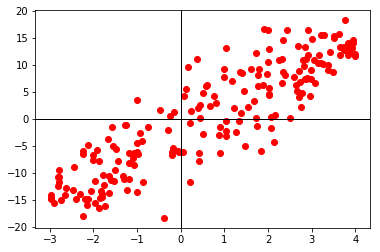

In [3]:
plt.plot(data_x, data_y, 'ro')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.show()

## Exact solution of linear regression

Linear regression model is
$$y_{\textrm{pred}} = \boldsymbol{w}^{\top}\boldsymbol{x} + b$$
or
$$y_{\textrm{pred}} = w_{0} + w_{1} x_{1} + w_{2} x_{2} + \cdots + w_{d} x_{d},$$
where $w_{0} = b$.

Extend the class of models by considering linear combinations of fixed nonlinear functions of the input variables

$$y_{\textrm{pred}} = w_{0} + w_{1} \phi_{1}(\mathbf{x}) + w_{2} \phi_{2}(\mathbf{x}) + \cdots + w_{M-1} \phi_{M-1}(\mathbf{x}),$$

$$y_{\textrm{pred}} = w_{0} + \sum_{j}^{M-1} w_{j} \phi_{j}(\mathbf{x}).$$

$\phi_{j}(\mathbf{x})$ is called *basis function*.
And add dummy 'basis function' $\phi_{0}(\mathbf{x}) = 1$ so that

$$y_{\textrm{pred}} = \sum_{j}^{M-1} w_{j} \phi_{j}(\mathbf{x}) = \mathbf{w}^{\top} \boldsymbol{\phi}(\mathbf{x}).$$

### Normal Equation (analytic solution of linear model)

$$\mathbf{w} = (\mathbf{\Phi}^{\top} \mathbf{\Phi})^{-1} (\mathbf{\Phi}^{\top} \mathbf{Y})$$

where $\mathbf{\Phi}$ is a $N \times M$ matrix, called *design matrix*

$$\mathbf{\Phi} = \left( \begin{array}{llll}
\phi_{0}(\mathbf{x_{1}}) & \phi_{1}(\mathbf{x_{1}}) & \cdots & \phi_{M-1}(\mathbf{x_{1}})\\
\phi_{0}(\mathbf{x_{2}}) & \phi_{1}(\mathbf{x_{2}}) & \cdots & \phi_{M-1}(\mathbf{x_{2}})\\
\vdots & \vdots & \ldots & \vdots\\
\phi_{0}(\mathbf{x_{N}}) & \phi_{1}(\mathbf{x_{N}}) & \cdots & \phi_{M-1}(\mathbf{x_{N}})
\end{array} \right).$$

And $\mathbf{Y}$ is a target vector (label data)
* $\mathbf{Y} = [y_{1}, y_{2}, \cdots, y_{N}]^{\top}$

### Problem

* This is a our problem.
$$y_{\textrm{pred}} = w_{0} + w_{1} x,$$

$$y_{\textrm{pred}} = \sum_{j}^{M-1} w_{j} \phi_{j}(\mathbf{x}) = \mathbf{w}^{\top} \boldsymbol{\phi}(\mathbf{x}).$$

* Write $\mathbf{\Phi}$ on your paper
  1. First, write $\phi_{0}(\mathbf{x})$ and $\phi_{1}(\mathbf{x})$.
  2. Second, consider how the design matrix $\mathbf{\Phi}$ looks like

## Implementation of exact solution (Normal equation)

### 1. Implement $\Phi$, $\mathbf{Y}$

* X: $\Phi$
* Y: $\mathbf{Y}$

In [4]:
# using data_x, data_y
X = np.concatenate((data_x.reshape(N, 1), np.ones(N).reshape(N, 1)), axis=1)
Y = data_y.reshape(N, 1)

### 2. Implement $\mathbf{w} = (\mathbf{\Phi}^{\top} \mathbf{\Phi})^{-1} (\mathbf{\Phi}^{\top} \mathbf{Y})$

* A: $\mathbf{\Phi}^{\top} \mathbf{\Phi}$
* invA: inverse of A
* B: $\mathbf{\Phi}^{\top} \mathbf{Y}$
* W_exact: $\mathbf{w}$ with shape: (2,)
* matrix inversion: `np.linalg.inv(A)`

In [5]:
%time
A = np.matmul(X.T, X)
invA = np.linalg.inv(A)
B = np.matmul(X.T, Y)
W_exact = np.matmul(invA, B)
W_exact = np.squeeze(W_exact)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 13.8 µs


In [6]:
#minima = W_exact.reshape(2, 1) # for 3D plot and contour plot
minima = np.flip(W_exact).reshape(2, 1) # for 3D plot and contour plot

In [7]:
print("Real parameters used creating the data")
print("w: {:.4f}  b: {:.4f}".format(a, b))
print("Exact Solution using the normal equation")
print("w: {:.4f}  b: {:.4f}".format(W_exact[0], W_exact[1]))

Real parameters used creating the data
w: 4.0000  b: -2.0000
Exact Solution using the normal equation
w: 4.1533  b: -2.2426


## Training Pseudo Code using Gradient Descent

```python
for epoch in max_epochs: # one epoch: when an ENTIRE dataset is passed through the model only ONCE
  for step in num_batches: # num_batches = int(data_size / batch_size)
    1. sampling mini-batches with batch_size
      1-1. data augmentation (when you need)
    2. calculate the logits # logits = f(x)
    3. calculate the loss # loss = loss(logits, labels)
    4. calculate the gradient with respect to weights
    5. update weights
```

## Build a LinearRegression model

In [8]:
class LinearRegression(object):
  def __init__(self, data_x, data_y, method='sgd',
               w_init=None, b_init=None, learning_rate=0.1, momentum=0.9):
    assert method in ['sgd', 'momentum', 'adagrad', 'rmsprop', 'adam']
    self.method = method
    scale = 4.0
    if w_init is not None:
      self.w = w_init
    else:
      self.w = np.random.uniform(low=a-scale, high=a+scale)
    if b_init is not None:
      self.b = b_init
    else:
      self.b = np.random.uniform(low=b-scale, high=b+scale)
    print("w_init: {:.3f}".format(self.w))
    print("b_init: {:.3f}".format(self.b))
      
    self.x = data_x
    self.y = data_y
    self.lr = learning_rate
    
    if self.method == 'momentum':
      self.momentum = momentum
      self.vw = 0.0
      self.vb = 0.0
      
    if self.method == 'adagrad':
      self.dw_squared = 0.1
      self.db_squared = 0.1
      self.epsilon = 1e-7
      
    if self.method == 'rmsprop':
      self.dw_squared = 0.0
      self.db_squared = 0.0
      self.decay = 0.9
      self.epsilon = 1e-10
      
    if self.method == 'adam':
      self.dw_first_moment = 0.0
      self.dw_second_moment = 0.0
      self.db_first_moment = 0.0
      self.db_second_moment = 0.0
      self.beta1 = 0.9
      self.beta2 = 0.999
      self.epsilon = 1e-8
    
    # for accumulation of loss and path (w, b)
    self.loss_history = []
    self.w_history = []
    self.b_history = []
  
  def inference(self, x):
    """Inference function for a linear model
      y_pred = w * x + b.
    
    Args:
      x: full-batch data, shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      y_pred: full-batch y_pred, shape: (1-rank Tensor (vector) np.array)
    """
    y_pred = self.w * x + self.b
    return y_pred
  
  def loss_for_plot(self, w, b):
    """List of loss function with respect to given list of (w, b).
      
    Args:
      w: shape: (1-rank Tensor (vector) np.array)
      b: shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      loss_for_plot: shape: (1-rank Tensor (vector) np.array)
    """
    y_pred = np.matmul(np.expand_dims(self.x, axis=1), np.expand_dims(w, axis=0)) + b
    loss_for_plot = 0.5 * (y_pred - np.expand_dims(self.y, axis=1))**2
    loss_for_plot = np.mean(loss_for_plot, axis=0)
    return loss_for_plot
  
  def loss_fn(self, labels, predictions):
    """Loss function.
    MSE loss
    
    Args:
      labels: target data y, shape: (1-rank Tensor (vector) np.array)
      predictions: model inference y_pred, shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      loss: mean value of loss for full-batch data, shape: (0-rank Tensor (scalar))
    """
    loss = 0.5 * np.mean((predictions - labels)**2)
    return loss
  
  def loss_derivative(self):
    """Loss derivative.
    
    Returns:
      dw: dL / dw, mean value of derivatives for full-batch data, shape: (0-rank Tensor (scalar))
      db: dL / db, mean value of derivatives for full-batch data, shape: (0-rank Tensor (scalar))
    """
    dw = np.mean((self.y_pred - self.y) * self.x)
    db = np.mean(self.y_pred - self.y)
    return dw, db
  
  def weights_update(self):
    """Weights update using Gradient descent.
    
      w' = w - lr * dL/dw
    """
    self.w = self.w - self.lr * self.dw
    self.b = self.b - self.lr * self.db
    
  def weights_update_momentum(self):
    """Weights update using Momentum.
    
      v' = gamma * v - lr * dL/dw
      w' = w + v'
    """
    self.vw = self.momentum * self.vw - self.lr * self.dw
    self.w = self.w + self.vw
    self.vb = self.momentum * self.vb - self.lr * self.db
    self.b = self.b + self.vb
    
  def weights_update_adagrad(self):
    """Weights update using adagrad.
    
      grads2 = grads2 + grads**2
      w' = w - lr * grads / (sqrt(grads2) + epsilon)
    """
    self.dw_squared = self.dw_squared + self.dw**2
    self.w = self.w - self.lr * self.dw / (np.sqrt(self.dw_squared) + self.epsilon)
    self.db_squared = self.db_squared + self.db**2
    self.b = self.b - self.lr * self.db / (np.sqrt(self.db_squared) + self.epsilon)
    
  def weights_update_rmsprop(self):
    """Weights update using RMSprop.
    
      grads2 = decay * grads2 + (1 - decay) * grad2**2
      w' = w - lr * graps / (sqrt(grad2) + epsilon)
    """
    self.dw_squared = self.decay * self.dw_squared + (1. - self.decay) * self.dw**2
    self.w = self.w - self.lr * self.dw / (np.sqrt(self.dw_squared) + self.epsilon)
    self.db_squared = self.decay * self.db_squared + (1. - self.decay) * self.db**2
    self.b = self.b - self.lr * self.db / (np.sqrt(self.db_squared) + self.epsilon)
    
  def weights_update_adam(self, time):
    """Weights update using Adam.
    
      g1 = beta1 * g1 + (1 - beta1) * grads
      g2 = beta2 * g2 + (1 - beta2) * g2
      g1_unbiased = g1 / (1 - beta1**time)
      g2_unbiased = g2 / (1 - beta2**time)
      w = w - lr * g1_unbiased / (sqrt(g2_unbiased) + epsilon)
    """
    self.dw_first_moment = self.beta1 * self.dw_first_moment + (1. - self.beta1) * self.dw
    self.dw_second_moment = self.beta2 * self.dw_second_moment + (1. - self.beta2) * self.dw**2
    self.db_first_moment = self.beta1 * self.db_first_moment + (1. - self.beta1) * self.db
    self.db_second_moment = self.beta2 * self.db_second_moment + (1. - self.beta2) * self.db**2
    
    self.dw_first_moment_unbiased = self.dw_first_moment / (1. - self.beta1**time)
    self.dw_second_moment_unbiased = self.dw_second_moment / (1. - self.beta2**time)
    self.db_first_moment_unbiased = self.db_first_moment / (1. - self.beta1**time)
    self.db_second_moment_unbiased = self.db_second_moment / (1. - self.beta2**time)
    
    self.w = self.w - self.lr * self.dw_first_moment_unbiased / (np.sqrt(self.dw_second_moment_unbiased) + self.epsilon)
    self.b = self.b - self.lr * self.db_first_moment_unbiased / (np.sqrt(self.db_second_moment_unbiased) + self.epsilon)
    
    
  def history_update(self, loss, w, b):
    """Accumulate all interesting variables
    """
    self.loss_history.append(loss)
    self.w_history.append(w)
    self.b_history.append(b)


  def train(self, max_epochs):
    pre_loss = 0.0
    print("epochs: {}  w: {:.5f}  b: {:.5f}".format(0, self.w, self.b))
    for epoch in range(max_epochs):
      self.y_pred = self.inference(self.x)
      self.loss = self.loss_fn(self.y, self.y_pred)
      self.history_update(self.loss, self.w, self.b)
            
      self.dw, self.db = self.loss_derivative()
      if self.method == 'momentum':
        self.weights_update_momentum()
      elif self.method == 'adagrad':
        self.weights_update_adagrad()
      elif self.method == 'rmsprop':
        self.weights_update_rmsprop()
      elif self.method == 'adam':
        self.weights_update_adam(epoch+1)
      else:
        self.weights_update()
        
      if epoch % 10 == 0:
        print("epochs: {}  loss: {:.6f}  w: {:.5f}  b: {:.5f}  dw: {:.5f}  db: {:.5f}".format(epoch, self.loss, self.w, self.b, self.dw, self.db))
      
      if np.abs(pre_loss - self.loss) < 1e-6:
        self.loss = self.loss_fn(self.y, self.y_pred)
        self.history_update(self.loss, self.w, self.b)
        break
      pre_loss = self.loss
    
    self.w_history = np.array(self.w_history)
    self.b_history = np.array(self.b_history)
    #self.path = np.concatenate((np.expand_dims(self.w_history, 1), np.expand_dims(self.b_history, 1)), axis=1).T
    self.path = np.concatenate((np.expand_dims(self.b_history, 1), np.expand_dims(self.w_history, 1)), axis=1).T

## Build a LinearRegression with Momentum model

### Create a `LinearRegression` class

In [9]:
w_init = 2.0
b_init = -15.0
lr = 0.37
model1 = LinearRegression(data_x, data_y, 'sgd', w_init=w_init, b_init=b_init, learning_rate=lr)
model2 = LinearRegression(data_x, data_y, 'momentum', w_init=w_init, b_init=b_init, learning_rate=lr, momentum=0.2)
model3 = LinearRegression(data_x, data_y, 'adagrad', w_init=w_init, b_init=b_init, learning_rate=lr)
model4 = LinearRegression(data_x, data_y, 'rmsprop', w_init=w_init, b_init=b_init, learning_rate=lr)
model5 = LinearRegression(data_x, data_y, 'adam', w_init=w_init, b_init=b_init, learning_rate=lr)

w_init: 2.000
b_init: -15.000
w_init: 2.000
b_init: -15.000
w_init: 2.000
b_init: -15.000
w_init: 2.000
b_init: -15.000
w_init: 2.000
b_init: -15.000


### Training

In [10]:
%time
max_epochs = 50
model1.train(max_epochs)

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 82 µs
epochs: 0  w: 2.00000  b: -15.00000
epochs: 0  loss: 121.202918  w: 9.00188  b: -9.75108  dw: -18.92400  db: -14.18627
epochs: 10  loss: 11.661103  w: 4.77643  b: -2.29243  dw: -3.51170  db: -0.79135
epochs: 20  loss: 10.376291  w: 4.25610  b: -2.22824  dw: -0.60596  db: -0.10511
epochs: 30  loss: 10.339332  w: 4.17082  b: -2.23970  dw: -0.10378  db: -0.01742
epochs: 40  loss: 10.338250  w: 4.15630  b: -2.24208  dw: -0.01776  db: -0.00297


In [11]:
%time
model2.train(max_epochs)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs
epochs: 0  w: 2.00000  b: -15.00000
epochs: 0  loss: 121.202918  w: 9.00188  b: -9.75108  dw: -18.92400  db: -14.18627
epochs: 10  loss: 10.338239  w: 4.15385  b: -2.24344  dw: -0.01092  db: -0.00565


In [12]:
%time
model3.train(max_epochs)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
epochs: 0  w: 2.00000  b: -15.00000
epochs: 0  loss: 121.202918  w: 2.36995  b: -14.63009  dw: -18.92400  db: -14.18627
epochs: 10  loss: 75.098610  w: 3.71093  b: -13.12182  dw: -9.82632  db: -11.32752
epochs: 20  loss: 61.058770  w: 4.29478  b: -12.30634  dw: -6.25609  db: -10.06976
epochs: 30  loss: 53.122698  w: 4.64345  b: -11.69291  dw: -4.06291  db: -9.19921
epochs: 40  loss: 47.803518  w: 4.86251  b: -11.18792  dw: -2.60794  db: -8.53336


In [13]:
%time
model4.train(max_epochs)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.9 µs
epochs: 0  w: 2.00000  b: -15.00000
epochs: 0  loss: 121.202918  w: 3.17004  b: -13.82996  dw: -18.92400  db: -14.18627
epochs: 10  loss: 34.066916  w: 5.16788  b: -9.13515  dw: 0.20974  db: -6.53998
epochs: 20  loss: 18.881082  w: 4.77094  b: -6.32700  dw: 0.31575  db: -3.89617
epochs: 30  loss: 12.467025  w: 4.44835  b: -4.22768  dw: 0.12783  db: -1.94941
epochs: 40  loss: 10.589029  w: 4.24875  b: -2.88839  dw: 0.04041  db: -0.66964


In [14]:
%time
model5.train(max_epochs)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.06 µs
epochs: 0  w: 2.00000  b: -15.00000
epochs: 0  loss: 121.202918  w: 2.37000  b: -14.63000  dw: -18.92400  db: -14.18627
epochs: 10  loss: 48.246543  w: 5.61593  b: -11.02792  dw: -0.13948  db: -8.32206
epochs: 20  loss: 30.545602  w: 6.18834  b: -7.90515  dw: 6.34296  db: -4.53884
epochs: 30  loss: 15.873097  w: 4.75016  b: -5.45648  dw: 1.33458  db: -2.93741
epochs: 40  loss: 11.716775  w: 3.97594  b: -3.60014  dw: -1.79665  db: -1.62488


### Results

In [15]:
print("Real parameters used creating the data")
print("w: {:.4f}  b: {:.4f}".format(a, b))
print("Exact Solution using the normal equation")
print("w: {:.4f}  b: {:.4f}".format(W_exact[0], W_exact[1]))
print("Solution using the gradient descent")
print("w: {:.4f}  b: {:.4f}".format(model1.w, model1.b))
print("Solution using the gradient descent with momentum")
print("w: {:.4f}  b: {:.4f}".format(model2.w, model2.b))
print("Solution using the gradient descent with adagrad")
print("w: {:.4f}  b: {:.4f}".format(model3.w, model3.b))
print("Solution using the gradient descent with rmsprop")
print("w: {:.4f}  b: {:.4f}".format(model4.w, model4.b))
print("Solution using the gradient descent with adam")
print("w: {:.4f}  b: {:.4f}".format(model5.w, model5.b))

Real parameters used creating the data
w: 4.0000  b: -2.0000
Exact Solution using the normal equation
w: 4.1533  b: -2.2426
Solution using the gradient descent
w: 4.1540  b: -2.2425
Solution using the gradient descent with momentum
w: 4.1531  b: -2.2424
Solution using the gradient descent with adagrad
w: 4.9885  b: -10.7940
Solution using the gradient descent with rmsprop
w: 4.1712  b: -2.3637
Solution using the gradient descent with adam
w: 4.1722  b: -2.4713


### Loss function plot

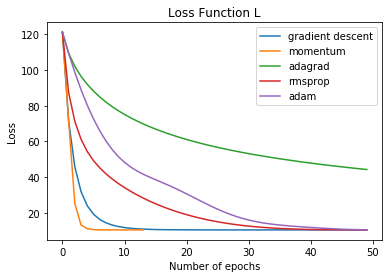

In [16]:
#Plot the loss function
plt.title('Loss Function L')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.plot(model1.loss_history, label='gradient descent')
plt.plot(model2.loss_history, label='momentum')
plt.plot(model3.loss_history, label='adagrad')
plt.plot(model4.loss_history, label='rmsprop')
plt.plot(model5.loss_history, label='adam')
plt.legend()
plt.show()

### Plot the data with our model

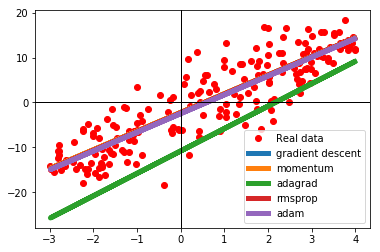

In [17]:
plt.plot(data_x, data_y, 'ro', label='Real data')
plt.plot(data_x, model1.w * data_x + model1.b, lw=5, label='gradient descent')
plt.plot(data_x, model2.w * data_x + model2.b, lw=5, label='momentum')
plt.plot(data_x, model3.w * data_x + model3.b, lw=5, label='adagrad')
plt.plot(data_x, model4.w * data_x + model4.b, lw=5, label='rmsprop')
plt.plot(data_x, model5.w * data_x + model5.b, lw=5, label='adam')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.legend()
plt.show()

## Plot loss surface function

In [18]:
# putting together our points to plot in a 3D plot
number_of_points = 50
w_margin = 9.
b_margin = 16.
w_min = a - w_margin
w_max = a + w_margin
b_min = b - b_margin
b_max = b + b_margin
w_points = np.linspace(w_min, w_max, number_of_points) 
b_points = np.linspace(b_min, b_max, number_of_points)
w_mesh, b_mesh = np.meshgrid(w_points, b_points)
loss_ = np.array([model1.loss_for_plot(wps, bps) for wps, bps in zip(w_mesh, b_mesh)])

### Static 3D plot with learning path

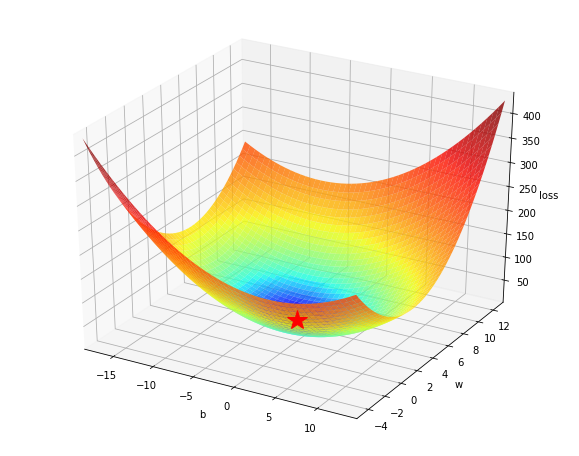

In [19]:
#%matplotlib inline
#%matplotlib notebook
#%pylab

path1 = model1.path
path2 = model2.path
path3 = model3.path
path4 = model4.path
path5 = model5.path

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d', elev=30, azim=-60)

ax.plot_surface(b_mesh, w_mesh, loss_, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)

ax.plot(*minima, model1.loss_for_plot(*np.flip(minima)), 'r*', markersize=20)
#ax.quiver(path1[0,:-1], path1[1,:-1], model1.loss_for_plot(*path1[::,:-1]),
#          path1[0,1:]-path1[0,:-1], path1[1,1:]-path1[1,:-1],
#          model1.loss_for_plot(*path1[::,1:]) - model1.loss_for_plot(*path1[::,:-1]),
#          color='k', length=0.5, normalize=True)

ax.set_xlabel('b')
ax.set_ylabel('w')
ax.set_zlabel('loss')

ax.set_xlim((b_min, b_max))
ax.set_ylim((w_min, w_max))

#plt.draw()
plt.show()

### Static contour plot with optimization path

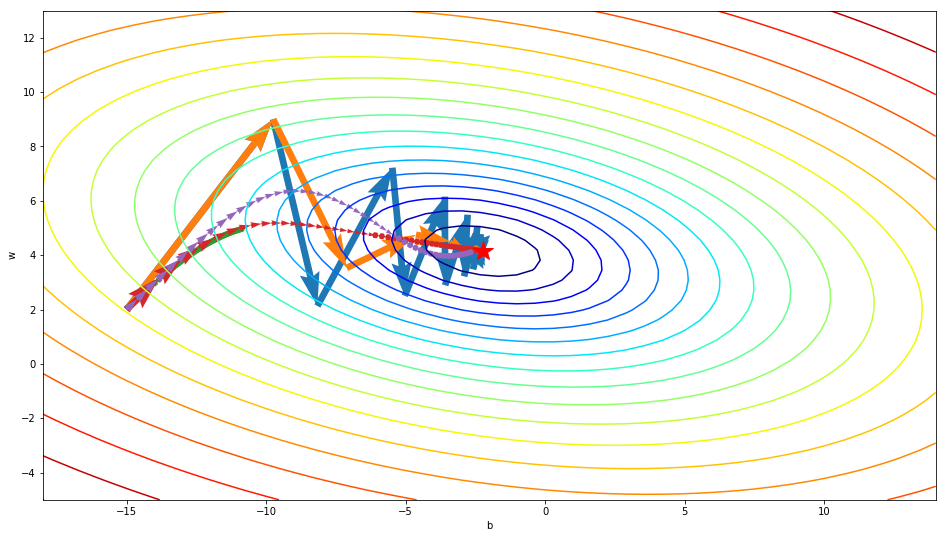

In [20]:
fig, ax = plt.subplots(figsize=(16, 9))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

ax.contour(b_mesh, w_mesh, loss_, levels=np.logspace(-1, 3, 45), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)
ax.quiver(path1[0,:-1], path1[1,:-1], path1[0,1:]-path1[0,:-1], path1[1,1:]-path1[1,:-1],
          scale_units='xy', angles='xy', scale=1.0, color=colors[0])
ax.quiver(path2[0,:-1], path2[1,:-1], path2[0,1:]-path2[0,:-1], path2[1,1:]-path2[1,:-1],
          scale_units='xy', angles='xy', scale=1.0, color=colors[1])
ax.quiver(path3[0,:-1], path3[1,:-1], path3[0,1:]-path3[0,:-1], path3[1,1:]-path3[1,:-1],
          scale_units='xy', angles='xy', scale=1.0, color=colors[2])
ax.quiver(path4[0,:-1], path4[1,:-1], path4[0,1:]-path4[0,:-1], path4[1,1:]-path4[1,:-1],
          scale_units='xy', angles='xy', scale=1.0, color=colors[3])
ax.quiver(path5[0,:-1], path5[1,:-1], path5[0,1:]-path5[0,:-1], path5[1,1:]-path5[1,:-1],
          scale_units='xy', angles='xy', scale=1.0, color=colors[4])

ax.set_xlabel('b')
ax.set_ylabel('w')

ax.set_xlim((b_min, b_max))
ax.set_ylim((w_min, w_max))

plt.show()

### Animation contour plot with optimization path

In [21]:
class TrajectoryAnimation(animation.FuncAnimation):
  def __init__(self, *paths, labels=[], colors=[], fig=None, ax=None, frames=None, 
               interval=60, repeat_delay=5, blit=True, **kwargs):
    if fig is None:
      if ax is None:
        fig, ax = plt.subplots()
      else:
        fig = ax.get_figure()
    else:
      if ax is None:
        ax = fig.gca()

    self.fig = fig
    self.ax = ax

    self.paths = paths

    if frames is None:
      frames = max(path.shape[1] for path in paths)

    self.lines = [ax.plot([], [], label=label, color=color, lw=3)[0] 
                  for _, label, color in zip_longest(paths, labels, colors)]
    self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                   for line in self.lines]

    super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                              frames=frames, interval=interval, blit=blit,
                                              repeat_delay=repeat_delay, **kwargs)

  def init_anim(self):
    for line, point in zip(self.lines, self.points):
      line.set_data([], [])
      point.set_data([], [])
    return self.lines + self.points

  def animate(self, i):
    for line, point, path in zip(self.lines, self.points, self.paths):
      line.set_data(*path[::,:i])
      point.set_data(*path[::,i-1:i])
    return self.lines + self.points

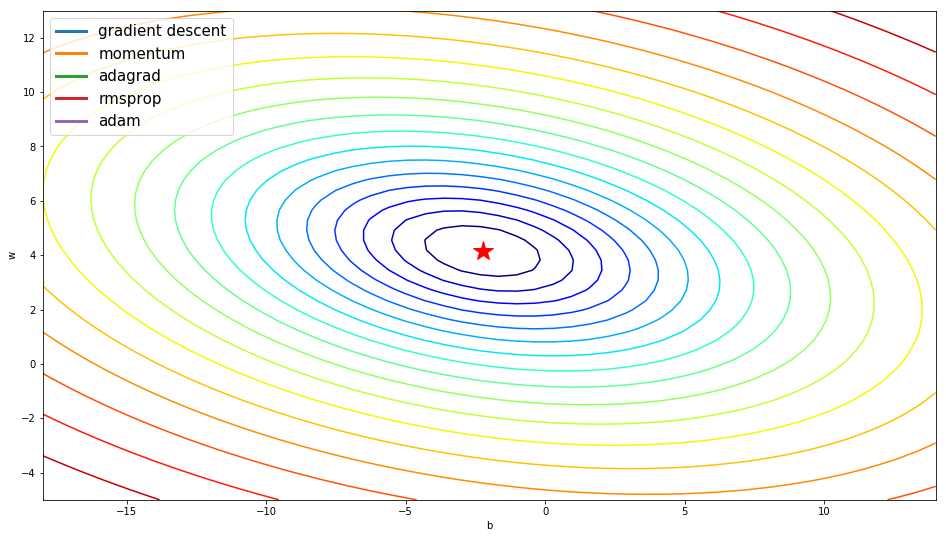

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.contour(b_mesh, w_mesh, loss_, levels=np.logspace(-1, 3, 45), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)

ax.set_xlabel('b')
ax.set_ylabel('w')

ax.set_xlim((b_min, b_max))
ax.set_ylim((w_min, w_max))

all_pathes = [path1, path2, path3, path4, path5]
opt_names = ['gradient descent', 'momentum', 'adagrad', 'rmsprop', 'adam']

#path_animation = TrajectoryAnimation(*all_pathes, labels=opt_names, colors=colors, ax=ax)
path_animation = TrajectoryAnimation(*all_pathes, labels=opt_names, colors=colors, ax=ax, interval=600)

ax.legend(loc='upper left', prop={'size': 15})

In [23]:
HTML(path_animation.to_html5_video())